In [2]:
#%run -i '../../scripts/utility_readblt.py' 'e4j'

In [1]:
from utility_common import *
from utility_plotter import *
import ROOT
from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
#%qtconsole --style monokai
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

Welcome to JupyROOT 6.13/02


# 1. Read data and MC as dataframe

In [2]:
selection  = "e4j"
pickledir  = "/mnt/data/zchen/Analysis/pickle/{}/".format(selection)

In [3]:
def prepare_df_list(nbjetcut):

    cuts = GetSelectionCut(selection) + "& (nBJets{})".format(nbjetcut)

    Data = LoadDataframe(pickledir + "data2016").query(cuts)
    MCzz = LoadDataframe(pickledir + "mcdiboson").query(cuts)
    MCdy = LoadDataframe(pickledir + "mcdy").query(cuts)
    MCt  = LoadDataframe(pickledir + "mct").query(cuts)
    MCtt = LoadDataframe(pickledir + "mctt").query(cuts)
    # signal mc is tt+tW
    MCsg = pd.concat([MCt,MCtt],ignore_index=True)

    MCsgf = MCsg.query('genCategory in [17,18,19,20,21] ') # semilep and had
    MCsg0 = MCsg.query('genCategory in [1,2,3,4,5,6,7,8,9,13,14,15]') #other lep
    MCsg1 = MCsg.query('genCategory in [16]') #e+j
    MCsg2 = MCsg.query('genCategory in [10,11,12]') #etau

    return [MCzz,MCdy,MCsgf,MCsg0,MCsg1,MCsg2,Data],MCt, MCtt


# 2. Plot kinematics

In [4]:
pp = pd.read_csv("plotparameters4j.csv")

label_list = ['Diboson','V+Jets',
              r'$tt/tW \rightarrow lh$ other',
              r'$tt/tW \rightarrow ll$ other',
              r'$tt/tW \rightarrow e + h$',
              r'$tt/tW \rightarrow e + \tau$',
              'data']
color_list = ["#a32020", "#e0301e", "#eb8c00", "#49feec", "deepskyblue", "mediumpurple", "k"]

In [5]:
for nbjetcut in ["==1",">1",">=1"]:
    df_list,_,__ = prepare_df_list(nbjetcut)
    plotoutdir = GetPlotDir(selection, nbjetcut)
    for index, row in pp.iterrows():
        v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
        
        plotter = SelectionPlotter(v,a,b,step,df_list)
        plotter.settingPlot(xl,label_list,color_list)
        plotter.makePlot(plotoutdir)

        print("making plots nbjet{0}: {1}/{2}".format(nbjetcut,index,len(pp)))
        clear_output(wait=True)
        plt.close()
        
print('finish all making plots')

KeyboardInterrupt: 

# 3. Counting

In [5]:
nbjetcut = ">=1"
df_list,MCt,MCtt = prepare_df_list(nbjetcut)
ctr = SelectionCounter()

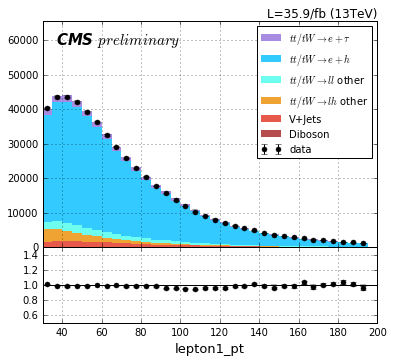

In [6]:
plt.rc("figure",facecolor="w",figsize=(6,4))

v,a,b,step,xl = "lepton1_pt",30,200,5,"lepton1_pt"
plotter = SelectionPlotter(v,a,b,step,df_list)
plotter.settingPlot(xl,label_list,color_list,plotWithoutXsErr=False)
plotter.makePlot()

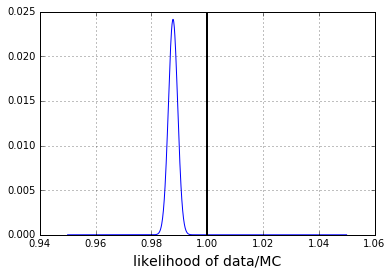

In [8]:
ratio = plotter.hdata/plotter.mctot
err   = sqrt((plotter.hdata**0.5/plotter.mctot)**2 + (plotter.mcerr/plotter.mctot)**2)


x = np.linspace(0.95,1.05,1000)
l = np.ones_like(x)
for i in range(len(ratio)):
    norm = (1/sqrt(2*np.pi*err[i]**2))
    l *= norm*np.exp(-(x-ratio[i])**2/(2*err[i]**2))
    #nll = nll+(x-ratio[i])**2/(2*err[i]**2)
l = l/np.sum(l)

plt.plot(x,l)
plt.xlabel("likelihood of data/MC",fontsize=14)
plt.axvline(1,c="k",lw=2)
plt.grid()

np.save("dataMCRatio/e4j_095to105", l)

In [20]:
print("(nBJets{})".format(nbjetcut))

print("MCtt: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=False)) )
print("MCtt width: {}".format(ctr.countSlt_ByTauDecay(MCtt,withweights=True)) )

print("MCt : {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=False)) )
print("MCt width: {}".format(ctr.countSlt_ByTauDecay(MCt, withweights=True)) )

(nBJets>1)
MCtt: [26030, 0, 11236, 296, 0, 177, 1513, 2, 10, 6559, 3070, 25242, 638, 0, 10, 606677, 60, 33999, 16, 364, 435]
MCtt width: [23275.689665993268, 0, 10074.26712880817, 261.4243763849931, 0, 159.46166704053059, 1319.6434342201835, 1.7897827166318891, 8.937795122265815, 5871.988741451032, 2745.770671793665, 22602.927742055563, 568.1852539879037, 0, 9.348271901607513, 547894.807458238, 51.32026452863589, 30212.035316034, 12.691549129374325, 322.43908224282785, 370.33017330126603]
MCt : [80, 0, 41, 0, 0, 0, 8, 0, 0, 17, 16, 87, 3, 0, 0, 2422, 1, 136, 0, 2, 1]
MCt width: [74.67986882459371, 0, 37.328172330837695, 0, 0, 0, 7.5840733933448785, 0, 0, 16.50112632393837, 14.67830893278122, 79.82229876480999, 2.4481548166275022, 0, 0, 2224.289410543137, 1.001450675725937, 124.58388739004732, 0, 2.0238260120153426, 0.000215124940732494]


In [21]:
ctr.countSlt_Scaled(df_list)

data:128975.0
TotalMC:130316.94269547907
------ MC break down ------
[5.09427863e+01 2.76287368e+03 6.11943074e+03 7.01768588e+03
 1.08219786e+05 6.14622390e+03]


In [22]:
for thisdf in [df_list[0],df_list[1], MCt, MCtt, df_list[-1]]:
    n = np.sum(thisdf.eventWeight)
    nerr = np.sum(thisdf.eventWeight**2)**0.5
    print('{:.2f},{:.2f}'.format(n,nerr))

50.94,2.50
2762.87,70.87
3357.10,65.18
124146.03,151.27
128975.00,359.13


In [21]:
# print Generator information
f = ROOT.TFile("../../data/root/2016MC.root")
print("MCtt : {}".format(ctr.countGen_ByTauDecay(f,'ttbar_inclusive')) )
temp = np.array(ctr.countGen_ByTauDecay(f,'t_tw'))
temp+= np.array(ctr.countGen_ByTauDecay(f,'tbar_tw'))
print("MCt  : {}".format(list(temp)) )

MCtt : [1811409.0, 1811532.0, 3620281.0, 57057.0, 54227.0, 111125.0, 418126.0, 418126.0, 763147.0, 642646.0, 626108.0, 2350887.0, 643368.0, 627277.0, 2353727.0, 22670017.0, 22653517.0, 4016590.0, 3923504.0, 14718933.0, 70930278.0]
MCt  : [23105.0, 23040.0, 46342.0, 694.0, 717.0, 1420.0, 5260.0, 5260.0, 9727.0, 8199.0, 8029.0, 30054.0, 8163.0, 8006.0, 29970.0, 290101.0, 289467.0, 50864.0, 50050.0, 187515.0, 904067.0]
